# Analysis of Molecular-dynamics Simulations of Protein Crystals - Diffuse
 
$\text{David Wych}^{1,2}, \text{Michael E. Wall}^{1}$

1. Computer, Computational and Statistical Sciences Division, Los Alamos National Laboratory, Los Alamos, NM 87545, USA
2. Center for Nonlinear Studies, Los Alamos National Laboratory, Los Alamos, NM 87545, USA

## Processing a trajectory for diffuse scattering calculation

In the notebook `Preparation_of_MD_Simulations_of_Protein_Crystals.ipynb` in the `crystalline_MD_prep/` directory, we showed how to prepare a protein crystal `.pdb` file from a `.pdb` of the asymmetric unit crystal structure, solvate and neutralize the system, and bring the system up to atmospheric pressure through iterative rounds of solvation and equilibration before running production simulation. Once one has a production simulation trajectory in hand (e.g. `production.xtc`), there are a few steps one must take before the trajectory can be used to calculate simulated diffuse scattering data.

First, one needs to construct a `reference_structure.pdb` file. To serve as a reference, this file needs to contain the exact coordinates for the protein after propagation to a supercell. However, as the system is solvated, equilibrated, and simulated in production the coordinates are periodic-boundary corrected, so atoms which lie outside of the periodic box are mapped to the other side of the box according to the periodic boundary conditions. This means that, over the course of solvation, equilibration, and production, the coordinates of the protein can be mapped very far from their positions in the original propagated supercell structure. Also, due to errors in floating point arithmetic, over the course of the trajectory, the coordinates of the atoms can drift from their initial positions.

To correct for both of of these effects, one must use the coordiantes of the initial propagated structure as a reference, fit the trajectory to these intial positions, and correct for the periodic boundary corrections, so the dynamics of the trajectory represent the lattice and internal motions of the system, and not articats of the simulation procedure itself.

To make such a reference structure, one must create a `.pdb` file with the atoms/coordinates from the initial propagated crystal structure, and the solvent atoms from the start of production (to ensure there are the same number of water/ion atoms in the reference structure as the production simulation).

The file should be constructed as follows:

`reference_structure.pdb`
```
CRYST1 ... ... ... <-- the CRYST1 record from the propagated supercell
ATOM ... |
ATOM ... | <-- coordinates from the original propagated supercell
ATOM ... |
TER
ATOM ... |
ATOM ... | <- coordinates of the solvent atoms from the end of
ATOM ... | <- equilibration or the start of production
ATOM ... |
```

**Note, again: It is very important that the protein coordinates should be the coordinates of the initial propagated supercell, and there should be an equal number of atoms in this file as there are in the production simulation. `GROMACS` will not be able to process the trajectory correctly otherwise. It is also important that all the molecules in the reference structure are in the same ordered as the molecules in the `.gro` file outputted at the start of production simulation, or exported using `gmx dump -s production.tpr -f production.xtc -o starting_structure_system.pdb -dump 0`; if they are not in the same order, `GROMACS` will not be able to process the trajectory correctly.**

- **Periodic Boundary Correction**
    - `gmx trjconv -s reference_structure.pdb -f production.xtc -o production_pbc_mol.xtc -pbc mol`
        - Maps atoms across the periodic boundary so that molecules are kept whole for the entire trajectory
    - `gmx trjconv -s reference_structure.pdb -f production_pbc_mol.xtc -o production_pbc_mol_nojump.xtc -pbc nojump`
        - Eliminates jumps from one side of the box to the other caused by the center of mass of the molecule crossing the periodic boundary.
    
- **Trajectory Fitting**
    - `echo "C-alpha System" | gmx trjconv -s reference_structure.pdb -f production_pbc_mol_nojump.xtc -o production_pbc_mol_nojump_fit.xtc -fit translation`
        - Minimizes the distance between the alpha carbons in the reference structure and the corresponding alpha carbons in the trajectory by translations, so protein atoms in all frames of the full trajectory are fit to the reference structure.

- **Downsampling and Subsampling**
    - `gmx trjconv -s reference_structure.pdb -f production_pbc_mol_nojump_fit.xtc -o trajectory.xtc -skip [number of frames to skip] -b [beginning (ps)] -e [end (ps)]`
        - skips a certain number of frames to downsample (e.g. if the original time step was 2 ps, `-skip 5` would produce a trajectory with 10 ps sampling). This step is important as trajectories can be very large and very long, so downsampling allows diffuse scattering to be calculated in a reasonable amount of time.
        - Only outputs the portion of the trajectory from `beginning` to `end` ps. This step is important, as the ensemble sampled in simulation takes a certain amount of time to reach equilibrium (as measured by, e.g. RMSD to the crystal structure -- run `gmx rmsd -h` for information on how to calculate this for the trajectory, using the `reference_structure.pdb` as the reference), and one wants to calculate diffuse scattering only after the simulation has reached the equilibrium state.
    
Once the trajectory has been periodic-boundary-corrected, fit, and downsampled, `xtraj.py` can be used to calculated simulated diffuse scattering from the trajectory.

## Computing structure factors and diffuse scattering from MD trajectory

Now let's switch gears and calculate the actual scattering from a simulation.

To do this, we're going to use a piece of software called `xtraj.py` in the `lunus` software suite for diffuse scattering. 

This script uses the coordiantes of the atoms, their atomic scattering factors, and the scattering equations to calculate the Bragg and Diffuse scattering predicted by the MD trajectory.

For the diffuse scattering the script uses Guinier's Equation:

$$I_{D} = \langle | F_{\text{crystal}} - \langle F_{\text{crystal}} \rangle |^{2} \rangle $$

where the diffuse intensity is the average scattering due to the difference of the stucture factors from the average.

To use the program to calcualte the diffuse scattering, we just let the program use the cell information from the supercell, which will give us a P1 space group for the supercell.

To calculate the Bragg scattering, we give `xtraj.py` the *real unit* cell box and space group information, and let it fold everything back on to the asymmetric unit, so we can examine the density superimposed on the protein structure.

*The unique thing about doing this analysis with MD is that we can calculate the density for the protein and solvent **separately**!*

---

We're going to need to collect the supercell side length and angle information from the CRYST1 record of the x-ray structure for later:

In [3]:
with open("./data/4wor_complete.pdb", 'r') as f:
    for line in f.readlines():
        if line[:6] == "CRYST1":
            with open("cell.txt", 'w') as f:
                a,b,c,alpha,beta,gamma = line.split()[1:7]
                f.write("{:.3f},{:.3f},{:.3f},{:.2f},{:.2f},{:.2f}".format(2*float(a),2*float(b),2*float(c),
                                                                     float(alpha),float(beta),float(gamma)))
                print("{:.3f},{:.3f},{:.3f},{:.2f},{:.2f},{:.2f}".format(2*float(a),2*float(b),2*float(c),
                                                                     float(alpha),float(beta),float(gamma)))

If we run xtraj without providing a unit cell and space group, lunus will read the information from the top of the topology file -- in this case, the cell and and space group information for a supercell, which is P1.

In [4]:
import os

In [5]:
xtraj=os.path.join(os.environ.get('LUNUS_PATH'),"lunus/command_line/xtraj.py")

In [7]:
!python {xtraj} \
        traj="trajectory.xtc" \
        top="crystal.pdb" \
        d_min=1.6 first=0 last=50 diffuse=diffuse_supercell.hkl \
        fcalc=fcalc_supercell.mtz icalc=icalc_supercell.mtz

f_000 = 469990, volume = 1.19358e+06
TIMING: md.iterload =  2.3310070037841797
Number of atoms in topology file =  129462
Rank  0  processed chunk  1  of  1
Rank  0  is done with individual calculations
TIMING: Calculate individual statistics =  76.62137413024902
TIMING: Reduction =  1.4619359970092773
TIMING: Total diffuse calculation =  75.70701289176941
Average Icalc:
 -60   -8    1    503215.88
 -60   -8    2    439694.19
 -60   -8    3    607274.38
 -60   -8    4    406870.24
 -60   -7    1    439702.61
 -60   -7    2    597343.05
 -60   -7    3    521224.58
 -60   -7    4    705288.33
 -60   -7    5    558011.31
 -60   -7    6    653130.11
 -60   -6    1    663376.98
Diffuse:
 -60   -8    1    391611.83
 -60   -8    2    413868.52
 -60   -8    3    406707.50
 -60   -8    4    378152.71
 -60   -7    1    390487.64
 -60   -7    2    519192.37
 -60   -7    3    482929.59
 -60   -7    4    579649.96
 -60   -7    5    397253.97
 -60   -7    6    548735.83
 -60   -6    1    517351.72


In [8]:
!python {xtraj} \
        traj="trajectory.xtc" \
        top="crystal.pdb" \
        d_min=1.6 first=0 last=50 selection="resname SOL" \
        diffuse=diffuse_supercell_wat.hkl \
        fcalc=fcalc_supercell_wat.mtz icalc=icalc_supercell_wat.mtz

f_000 = 171372, volume = 1.19358e+06
TIMING: md.iterload =  2.315333127975464
Number of atoms in topology file =  129462
Rank  0  processed chunk  1  of  1
Rank  0  is done with individual calculations
TIMING: Calculate individual statistics =  51.038153886795044
TIMING: Reduction =  1.4170081615447998
TIMING: Total diffuse calculation =  50.09851908683777
Average Icalc:
 -60   -8    1    217823.80
 -60   -8    2    224121.96
 -60   -8    3    196776.81
 -60   -8    4    199629.90
 -60   -7    1    187425.46
 -60   -7    2    197612.65
 -60   -7    3    299782.12
 -60   -7    4    234118.90
 -60   -7    5    225820.76
 -60   -7    6    283695.84
 -60   -6    1    282392.21
Diffuse:
 -60   -8    1    214984.03
 -60   -8    2    212955.48
 -60   -8    3    196137.85
 -60   -8    4    198911.32
 -60   -7    1    182023.74
 -60   -7    2    179544.12
 -60   -7    3    298946.16
 -60   -7    4    207101.70
 -60   -7    5    198274.81
 -60   -7    6    278856.84
 -60   -6    1    282236.17


In [9]:
!python {xtraj} \
        traj="trajectory.xtc" \
        top="crystal.pdb" \
        d_min=1.6 first=0 last=50 selection="not resname SOL" \
        diffuse=diffuse_supercell_prot.hkl \
        fcalc=fcalc_supercell_prot.mtz icalc=icalc_supercell_prot.mtz

f_000 = 298618, volume = 1.19358e+06
TIMING: md.iterload =  2.315343141555786
Number of atoms in topology file =  129462
Rank  0  processed chunk  1  of  1
Rank  0  is done with individual calculations
TIMING: Calculate individual statistics =  60.187963247299194
TIMING: Reduction =  1.4523026943206787
TIMING: Total diffuse calculation =  59.28221893310547
Average Icalc:
 -60   -8    1    279493.21
 -60   -8    2    215861.22
 -60   -8    3    476409.84
 -60   -8    4    196703.71
 -60   -7    1    265792.95
 -60   -7    2    293379.47
 -60   -7    3    244212.63
 -60   -7    4    396749.16
 -60   -7    5    237278.79
 -60   -7    6    383856.64
 -60   -6    1    339784.82
Diffuse:
 -60   -8    1    192406.14
 -60   -8    2    212731.70
 -60   -8    3    253382.94
 -60   -8    4    162878.82
 -60   -7    1    195159.25
 -60   -7    2    248461.73
 -60   -7    3    199058.45
 -60   -7    4    318933.41
 -60   -7    5    180511.62
 -60   -7    6    286960.18
 -60   -6    1    189359.78


## Taking a look at the diffuse scattering

We're simply going to load in the `.hkl` diffuse scattering file produced by `xtraj.py` but note that this is only for visualization purposes; the actual diffuse scattering should be converted to a lattice with scattering vector units, the lattice we're about to look at is in Miller index units.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def show_diffuse(filename):
    H,K,L,I = np.loadtxt(filename, dtype=[("h", int), ("k", int), ("l", int), ("I", float)], unpack=True)
    Hmax = H.max(); Hmin = H.min()
    Kmax = K.max(); Kmin = K.min()
    Lmax = L.max(); Lmin = L.min()
    mat_size = (Hmax-Hmin+1, Kmax-Kmin+1, (2*Lmax)+1)
    del H, K, L, I
    data_mat = np.empty(mat_size)
    with open(filename, 'r') as f:
        for line in f.readlines():
            h = int(line.split()[0]) - Hmin
            k = int(line.split()[1]) - Kmin
            l_1 = int(line.split()[2]) + Lmax
            l_2 = Lmax - int(line.split()[2])
            data_mat[h,k,l_1] = float(line.split()[3])
            data_mat[h,k,l_2] = float(line.split()[3])
            
    
    return data_mat

In [12]:
diffuse = show_diffuse("diffuse_supercell.hkl")
diffuse_wat = show_diffuse("diffuse_supercell_wat.hkl")
diffuse_prot = show_diffuse("diffuse_supercell_prot.hkl")

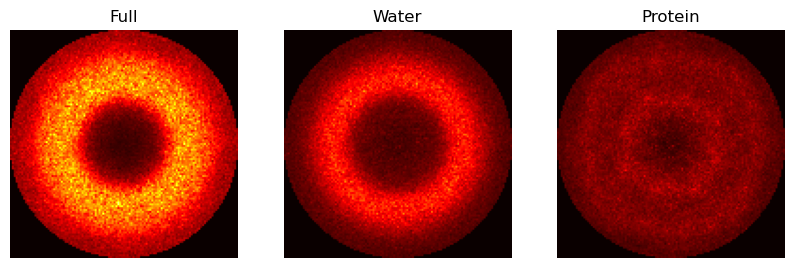

In [13]:
f, ax = plt.subplots(figsize=(10,10), ncols=3)
import matplotlib.colors
ax[0].imshow(diffuse[:,:,81], vmax=0.95*diffuse.max(), cmap=plt.cm.hot, origin="lower")
ax[0].set_title("Full")
ax[0].set_axis_off()
ax[1].imshow(diffuse_wat[:,:,81], vmax=0.95*diffuse.max(), cmap=plt.cm.hot, origin="lower")
ax[1].set_title("Water")
ax[1].set_axis_off()
ax[2].imshow(diffuse_prot[:,:,81], vmax=0.95*diffuse.max(), cmap=plt.cm.hot, origin="lower")
ax[2].set_title("Protein")
ax[2].set_axis_off()

The figure above compares the full diffuse scattering with the scattering from the water and protein components of the system.

Next we'll examine the diffuse scattering measured in experiment.

## Examining the experimental diffuse scattering

The `lunus` software package contains many methods that may be used to analyze and process diffuse scattering data. The native internal data structure for packaging diffuse scattering maps in this software package is the binary `.lat` file. Below we introduce a `python` script which uses native `python` and `numpy` methods to read in these files as byte arrays, and outputs both the information from the header, and the lattice itself (stored as a `numpy` array): 

In [14]:
import struct

def read_lat(filename):
    # open and read the file, then store it as a bytearray
    fh = open(filename, "rb")
    ba = bytearray(fh.read())
    # The first 36 bytes are information about the data
    Nx,Ny,Nz,xlo,xhi,ylo,yhi,zlo,zhi=struct.unpack('=IIIffffff',ba[0:36])
    header_info = (Nx, Ny, Nz, xlo, xhi, ylo, yhi, zlo, zhi)
    print(f"Dimensions\n----------\n x: {Nx}, y: {Ny}, z:{Nz}")
    print(f"Data bounds\n-----------\n x: ({xlo:.4f},{xhi:.4f})\n y: ({ylo:.4f},{yhi:.4f})\n z: ({zlo:.4f},{zhi:.4f})")
    # Load the rest of the file in to a numpy array
    arr=np.frombuffer(ba[36:],dtype=np.float32)
    # reshape to a matrix Nx by Ny by Nz
    lat=np.reshape(arr,(Nz,Ny,Nx))
    return header_info, lat

With the file loaded in as a `numpy` array, we can use `matplotlib`'s `imshow` to view the diffuse scattering. Here we take a slice through the middle of the z-axis (as the z-axis is 160 elements, the middle is the 80th slice). (Also, the value -32767 is used as a tag that indicates that data should be ignored, so we set all elements of the image slice through the array with that value to zero).

Dimensions
----------
 x: 122, y: 122, z:160
Data bounds
-----------
 x: (-0.6183,0.6286)
 y: (-0.6183,0.6286)
 z: (-0.6221,0.6299)


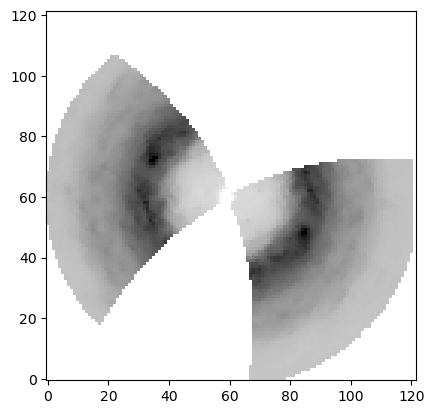

In [15]:
header, lattice = read_lat("experimental_data.lat")
im=1.*lattice[80]
im[im == -32767.0] = 0
plt.imshow(im,vmin=0,vmax=3100, cmap=plt.cm.Greys, origin="lower");

## Calculating the isotropic diffuse scattering

The isotropic diffuse scattering is a familiar form of diffuse scattering that is ubiquotous in protein crystallography. We can calculate it by averaging the diffuse signal in resolution shells. First, we illustrate a way to do this using experimental and simulated data from the Wych et al. 2019 Structural Dynamics paper. These files are available in the `data/` directory in the `lunus` internal `.lat` binary format. The method makes use of `lunus.avgrlt` to take averages of the data in the `.lat` file in spherical shells eminating from the origin. These are stored in a `.rf` binary file (a simple legacy format from the Sol Gruner lab 1990s) which is converted to a `.dat` text file for plotting using `lunus.binasc`.

Below we use the code `calc_isotropic.sh` which takes in a `.lat` file, and uses `lunus.avgrlt` and `lunus.binasc` methods to calcualte the isotropic profile, and output the data in resolution bins in an ASCII `.dat` format, which we can then plot.

`calc_isotropic.sh`
```bash
#!/bin/bash

# arguments:
# 1: diffuse .lat file

IN=$1

lunus.avgrlt $IN ${IN%.lat}_isotropic.rf $(cat cell.txt)
lunus.binasc 2 < ${IN%.lat}_isotropic.rf > ${IN%.lat}_isotropic.dat
```

We calculate the isotropic signal from both the simulated and experimental diffuse data, and then plot them, scaling the simulated data.

In [31]:
%%capture
!bash ./code/calc_isotropic.sh simulated_data.lat
!bash ./code/calc_isotropic.sh experimental_data.lat

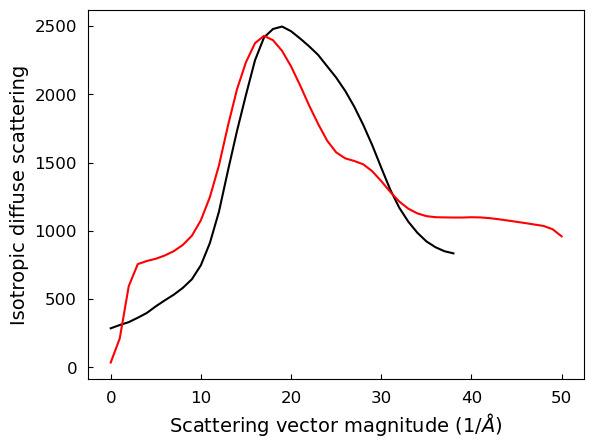

In [40]:
q_sim, iso_sim = np.loadtxt("simulated_data_isotropic.dat").T
q_exp, iso_exp = np.loadtxt("experimental_data_isotropic.dat").T

f, ax = plt.subplots()

ax.plot(q_sim, iso_sim/550., c="k")
ax.plot(q_exp, iso_exp, c="r")
ax.set_xlabel(r"Scattering vector magnitude (1/$\AA$)", size=14)
ax.set_ylabel("Isotropic diffuse scattering", size=14)
ax.tick_params(axis="both", direction="in", labelsize=12, pad=8)

The isotropic diffuse signal is sometimes called the "solvent ring" because it is assumed to result from scattering from the solvent. Let's investigate how true this assumption is, using our simulated diffuse intensities computed from the MD simulation (note: the trajectory we are analyzing is quite short -- 50ns; however the analysis we show here is consistent with similar analysis on much longer trajectories \[see [Wall 2014](https://www.pnas.org/doi/abs/10.1073/pnas.1416744111)\]).

First we use `lunus.makelt` to generate a template lattice the correct miller indices based on the supercell box and space group information and the resolution (1.6 angstroms). We then use `hkl2lat` to convert the `xtraj.py` produced `.hkl` diffuse scattering file to a `.lat` file with the experimental data as a template. 

We're going to need to convert the diffuse scattering files in the flat text `.hkl` format to the internal binary format for `lunus` which is a `.lat` file. To do this using `lunus`, we'll need a `.lat` template. 

Below, we use the experimental data in the `.lat` format, provided in the `data/` directory. 

(If this is not avaiable, a template can be created with the following command using the `supercell_cell.txt` file created above:)

In [14]:
# !lunus.makelt template.lat $(cat cell.txt) 1.6

We then convert the diffuse scattering in the `.hkl` format to a file in the `.lat` format using `hkl2lat`.

In [33]:
!lunus.hkl2lat diffuse_supercell.hkl diffuse_supercell.lat experimental_data.lat

origin: 60 60 79
122 122 160 2381440
Initializing the hkl file data...
Reading the hkl file data...
...done
Writing file
Done writing file


In [36]:
%%capture
!lunus.hkl2lat diffuse_supercell_wat.hkl diffuse_supercell.lat experimental_data.lat
!lunus.hkl2lat diffuse_supercell_wat.hkl diffuse_supercell_wat.lat experimental_data.lat
!lunus.hkl2lat diffuse_supercell_prot.hkl diffuse_supercell_prot.lat experimental_data.lat

!bash ./code/calc_isotropic.sh diffuse_supercell.lat
!bash ./code/calc_isotropic.sh diffuse_supercell_wat.lat
!bash ./code/calc_isotropic.sh diffuse_supercell_prot.lat

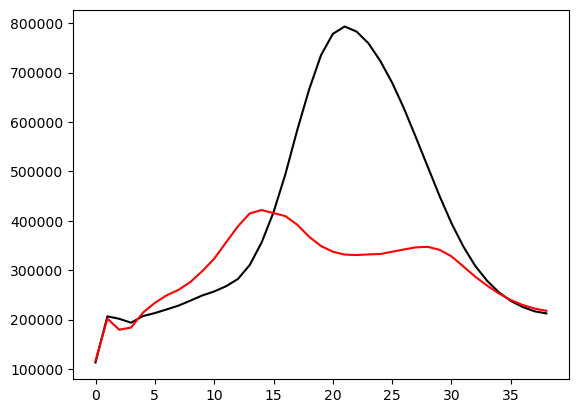

In [45]:
q, iso = np.loadtxt("diffuse_supercell_isotropic.dat").T
q_wat, iso_wat = np.loadtxt("diffuse_supercell_wat_isotropic.dat").T
q_prot, iso_prot = np.loadtxt("diffuse_supercell_prot_isotropic.dat").T
f, ax = plt.subplots()
ax.plot(q, iso, c="k", label="Full")

ax.plot(q_prot, iso_prot, c="r", label="Protein")

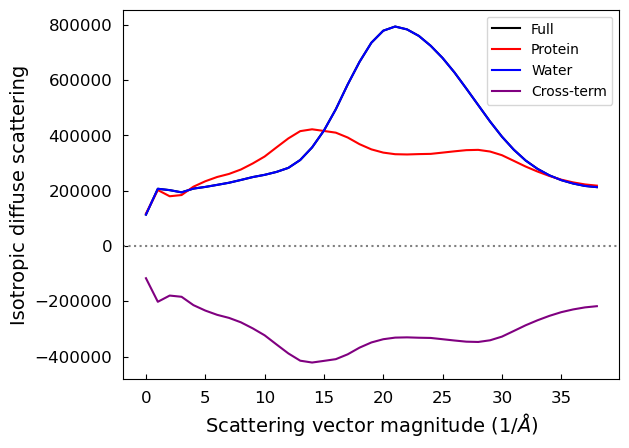

In [41]:
q, iso = np.loadtxt("diffuse_supercell_isotropic.dat").T
q_wat, iso_wat = np.loadtxt("diffuse_supercell_wat_isotropic.dat").T
q_prot, iso_prot = np.loadtxt("diffuse_supercell_prot_isotropic.dat").T
q_cross = q
iso_cross = iso - iso_wat - iso_prot

f, ax = plt.subplots()

ax.plot(q, iso, c="k", label="Full")
ax.plot(q_prot, iso_prot, c="r", label="Protein")
ax.plot(q_wat, iso_wat, c="b", label="Water")
ax.plot(q_cross, iso_cross, c="Purple", label="Cross-term")
ax.axhline(0, c="Grey", ls=":")
ax.legend(loc="upper right")
ax.set_xlabel(r"Scattering vector magnitude (1/$\AA$)", size=14)
ax.set_ylabel("Isotropic diffuse scattering", size=14)
ax.tick_params(axis="both", direction="in", labelsize=12, pad=8)

Notice that the isotropic scattering has contributions from both the protein and solvent, as well as the protein-solvent cross term.

---

It's worth noting, before we move on, that the crystalline MD model is currently the only model available which can produce predictions of _both_ the isotropic and anisotropic diffuse scattering. Other popular models, including the liquid-like motions (LLM) model, rigid-body motions (RBM) model, and elastic-network/normal-models (EN/NM) models, are only designed to model the anisotropic diffuse scattering. The crystalline MD model can predict both. However, an important difference between these models is the fact that the LLM, RBM, and EN/NM models are _refined_ against the experimental data, whereas the MD model is not. The only input that the MD model gets from experiment is the structure from which the model is produced. Otherwise, the MD model depends almost entirely on the force field, and the parameters of the simulation (restrained or unrestrained; the solvent model; etc.). Because the other models are _refined_, they have (so far) been able to show better agreement with the anisotropic data than the MD model.

---

## Anisotropic Scattering

After subtracting the isotropic scattering (the average in spherical shells moving away from the origin in reciprocal space) one is left with the *anisotropic* diffuse scattering. This component of the diffuse scattering is of interest because it results mainly from scattering from the protein only (rather than from the solvent, or protein-solvent dynamics). So, by studying the anisotropic diffuse scattering, one can see how accurately the model is reproducing the dynamics of the protein. 

Using `lunus`, one can calculate the anisotropic diffuse scattering with the method `anisolt`. Then, to calculate the agreement between the anisotropic scattering from the model, and from the experimental data there are two options:

- Calculating the full map correlation coefficient using `lunus`' `corrlt` method
    - This method calculates the Pearson correlation coefficient between two lattices (`.lat` files).
    - `lunus.corrlt simulated_data.lat experimental_data.lat`
    
- Calculating the correlation coefficient between the simulated and experimental data in bins sorted by resolution
    - This method segments reciprocal space in to spherical shells moving out from the origin, and calculates the correlation coefficient between data points in each shell.
    - `lunus.ccrlt simulated_data.lat experimental_data.lat`
    

If the two diffuse scattering maps extend to different resolutions, the  the higher-resolution map can be culled to match the size of the lower-resolution map, using `lunus`' `cullreslt` method. In an example case where the simulated data extends to 1.6 angstrom resolution, and the experimental data extends further, `cullreslt` can be used to cull the map as follows: 
    
`lunus.cullreslt experimental_data.lat experimental_data_culled.lat 200.0 1.6`
    
(where 200.0 angstroms is used as the low-resolution cutoff).

---

Below we use a helper script (`calculate_correlation.sh` in the `/code/` sub-directory) which processes the simulated data from our 2019 Structural Dynamics paper (a 400ns 2x2x2 simulation of *staphyloccocal nuclease* using the `CHARMM27` force field), and computes the full-map correlation coefficient between the simulated and experimental data, calculates the anisotropic diffuse scattering for both maps, and computes both the full-map correlation coefficient between the two anisotropic diffuse scattering maps, and the correlation coefficient in resolution bins. We then plot the correlation coefficient as a function of resolution.

In [20]:
%%capture
!bash ./code/calculate_correlation.sh experimental_data.lat simulated_data.lat

In [21]:
!echo "FULL MAP CORRELATION COEFFICIENT"
!cat full_map_correlation_coefficient.txt
!echo "ANISOTROPIC COMPONENT CORRELATION COEFFICIENT"
!cat anisotropic_component_correlation_coefficient.txt

FULL MAP CORRELATION COEFFICIENT
0.907549
ANISOTROPIC COMPONENT CORRELATION COEFFICIENT
0.624367


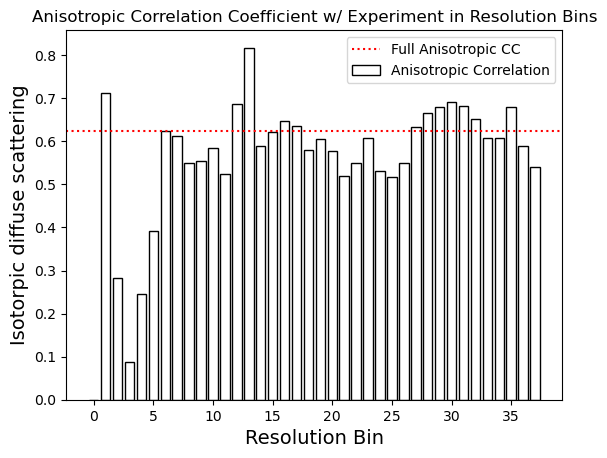

In [22]:
q, corr = np.loadtxt("anisotropic_correlation_in_bins.dat").T
f, ax = plt.subplots()
ax.set_title("Anisotropic Correlation Coefficient w/ Experiment in Resolution Bins")
ax.bar(q,corr,align="center", color="white", edgecolor="k", label="Anisotropic Correlation")
ax.axhline(0.624367, c="r", ls=":", label="Full Anisotropic CC")
ax.set_xlabel("Resolution Bin", size=14)
ax.set_ylabel("Isotorpic diffuse scattering", size=14)
ax.legend();

## Atomic covariance of atom pairs as a function of distance

### Why compute the covariance?

For the understanding of diffuse scattering, an important quantity to compute is the **variance-covariance matrix of atomic displacements**: $\mathbf{V}_{jk} = \langle \mathbf{u}_{j}\mathbf{u}_{k} \rangle_{t}$ where $\mathbf{u} = \mathbf{r} - \langle \mathbf{r} \rangle_{t}$. This is a 3x3-element symmetric matrix for each pair of atoms in the crystal, whose elements are the displacement covariances of the atoms along each axis. The first row is the x-x, x-y, and x-z displacement covariance of atoms $j$ and $k$ -- that is, the degree to which the displacements about the mean of atoms $j$ and $k$ are correlated with each other: high values indicate that the atoms tend move similarly along the associated axes. 

The variance-covariance matrix of atomic displacements shows up the in the equation for the diffuse intensity ($I_{D}(\mathbf{q})$) from atoms $j$ in unit cells $\mathbf{n}$ and atoms $k$ in unit cells $\mathbf{m}$, under an assumption of harmonic displacements about the atoms' average positions. It is the only variable which is not indpendently known/calculated ($f(q)$) or refined as part of standard Bragg refinement ($\mathbf{R}_n, \langle r_j \rangle, T_{j}(\mathbf{q})$):

$$I_D(\mathbf{q})=\sum_{\mathbf{n}j} \sum_{\mathbf{m}k} f_j(q) f^{\ast}_k(q) e^{i\mathbf{q}\cdot(\mathbf{R}_n-\mathbf{R}_m)}e^{i\mathbf{q}\cdot(⟨\mathbf{r}_j⟩-⟨\mathbf{r}_k⟩)} T_j(\mathbf{q}) T_k(\mathbf{q})\{e^{\mathbf{q}^T \textbf{V}_{\mathbf{n}j\mathbf{m}k}\mathbf{q}}-1\}$$

Besides the diffuse scattering, one might be interested in computing the covariance simply as a means to better understanding the protein's correlated dynamics. For instance, if one wanted to understand the effect of ligand binding on a protein's allosteric network and changes in associated dynamics, one could simulate the protein with and without the ligand bound and look at the difference in the atom-pair covariance matrices to understand how the protein's dynamics change. This can provide a quantitative complement to more qualitative analysis, like simply analyzing the trajectory.

### How the covariance is computed

The MD trajectory consists of a series of coordinates $\mathbf{X}_{t} = (\mathbf{r}_{1}(t), \mathbf{r}_{2}(t), \dots \mathbf{r}_{N}(t))$ for each atom $i$ at each time point $t$ of the simulation.

From this trajectory, we can compute many useful quantities. 

For example: the metric one would use to get a sense for how far the trajectory has strayed from the crystal structure (the starting position) is the root mean square deviation (RMSD) to the crystal structure, at each time point (t) of the trajectory:

$$ \text{RMSD}(\mathbf{X}_t) = \sqrt{ \frac{1}{N} \sum_{n} (\mathbf{r}_{n}(t_i) - \langle \mathbf{r}_{n} \rangle_{t})^{2}} $$

To save on compute, we calculated the covariance for only the backbone $\alpha$-carbons in our system (a crystalline simulation of *staphyloccocal nuclease*) and computed the "atomic covariance" (sometimes called the "total variance") or the sum of the x-x, y-y, and z-z covariances (the $\mathrm{Trace}$ of our matrix $\mathbf{V}_{jk}$), because we want to be able to plot a relationship between the average separation distance and the covariance for each atom pair, and for that we need a single-valued quantity to represent the covariance (as opposed to a matrix).

`GROMACS` provides a way to calculate both the average positions of the atoms and the covariance (or even the atomic covariance) with the same method: `gmx covar`.

`gmx covar` takes the arguments:
- `-f`: the (`.xtc`/`.trr`) trajectory file
- `-s`: the (`.pdb`/`.gro`) structure file
- `-av`: the name of the file for the average positions for the atoms (in, e.g., the `.gro` or `.pdb` format)
- `-ascii`: the name of the output atomic covariance matrix file (in ASCII format)
- `-fit`: perform trajectory fitting

Below is an example command for computing the atomic covariances matrix for the short, example simulation trajectory provided in `/traj_files/` (select the `C-alpha` coordinates for processing). 

However, this trajecotry does not have the sampling or amount of data necessary to produce the results from the *structural Dynamics* paper, so we provide the pre-processed pair-wise distance and atomic-covariance matrices from the full trajectory in `/data/`.

In [23]:
# gmx covar -f traj_files/c_alpha_first_first_100ns_500_frames_fit.xtc -s traj_files/c_alpha_start.pdb -av average_position.pdb -ascii atomic_covariance.dat -fit

With the `average_position.pdb` file in hand, one can load in the positions of the atoms to a numpy array, and compute the pair-wise distances, with a python script like examples script provided in the `/code/` directory: `pairwise_distances.py`.

To select only the alpha carbons from a `.pdb` file, one can use a `python` script like the following (in `/code/`) which processes the file `full_sys_start.pdb` contained in the `/data/` directory, and outputs a pdb file containing only the alpha carbons:

`get_c_alphas.py`
```python
with open("./data/full_sys_start.pdb", 'r') as f:
    with open("full_sys_start_calphas.pdb", 'w') as g:
            for line in f.readlines():
            # keep the CRYST1 record
            if line[:6] == "CRYST1":
                g.write(line)
            # keep the alpha carbons (name CA)
            if line[:4] == "ATOM":
                if line[12:16].strip() == "CA":
                    g.write(line)
            # don't write anything else
            else:
                pass
```

Then one can process the alpha carbon `.pdb` file to get the pairwise distances, correcting for periodic boundary conditions (e.g. atoms very far from each other in the box can, in reality, be very close to each other, modulo the periodic boundary) by using the `python` call below. 

(Remove the comment `#`s in the code blocks below to see what the pairwise distance matrix looks like for the starting structure supercell file provided in `/data/`. Note that this will look very similar to the pairwise distance matrix we use in the analysis below, but it is not the same -- the pairwise distance and atomic covariance matrices used below were calculated from a much longer trajectory, which would have been impractical to include in this tutorial.)

In [24]:
# !python ./code/get_c_alphas.py
# !python ./code/pairwise_distances.py --pdb full_sys_start_calphas.pdb --out pairwise_distances.npy

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# np.load("pairwise_distances.npy")
# f, ax = plt.subplots(figsize=(7,7))
# pos = ax.imshow(x, cmap=plt.cm.Blues, origin="lower");
# f.colorbar(pos, fraction=0.046, pad=0.04);
# ax.set_title(r"$\alpha$-carbon atom pair distance ($\AA$)");
# plt.show()

The atomic covariance between atom pairs and the average c-$\alpha$ positions were both computed from an MD trajectory of a 2x2x2 unit cell simulation of *staphyloccocal nuclease* using GROMACS. The atomic covariance and pairwise distances (computed as above) have been stored in `numpy` `.npy` array files in `/data/`. 

Below we plot them:

In [25]:
# atomic covariance is in units of nm² - 1 nm² = 100 Å²
covar = 100*np.load("./data/amber_tot_var_mat.npy")
# distance is in units of nm - 1 nm = 10 Å
dist  =  10*np.load("./data/amber_average_sc_c_alpha_distances_pbc.npy")

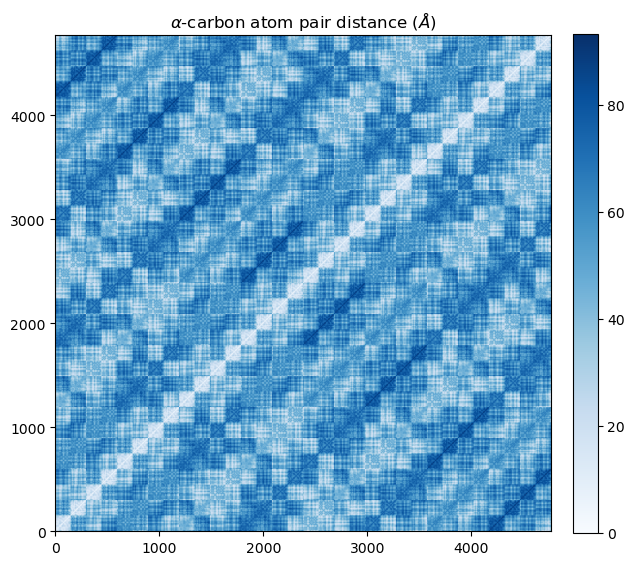

In [26]:
f, ax = plt.subplots(figsize=(7,7))
pos = ax.imshow(dist, cmap=plt.cm.Blues, origin="lower");
f.colorbar(pos, fraction=0.046, pad=0.04);
ax.set_title(r"$\alpha$-carbon atom pair distance ($\AA$)");

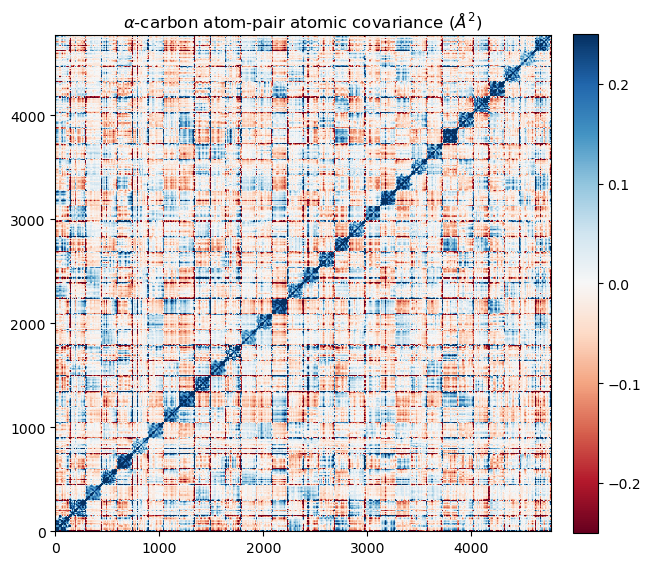

In [27]:
import matplotlib.colors as colors
f,ax = plt.subplots(figsize=(7,7))
pos = ax.imshow(covar, vmin=-0.25, vmax=0.25, cmap=plt.cm.RdBu, origin="lower");
f.colorbar(pos, fraction=0.046, pad=0.04);
ax.set_title(r"$\alpha$-carbon atom-pair atomic covariance ($\AA^{2}$)");

To see the relationship between covariance and atom-pair distance, we need to match up the elements of the atomic covariance matrix and the average distance matrix. However, because the matrix is symmetric (the average distance between atom 1 and 10 is the same as the average distance between atom 10 and 1 -- and similarly for atomic covariance) we need to look at only the upper triangular elements of each matrix. (We exclude the diagonal because we are not interested in the movement of individual atoms, only the _relative_ movement of atom _pairs_.)

We achieve this by masking out the lower triangular elements and the elements along the diagoal (`numpy`'s `triu_indices` method produces a matrix of indices of size `n` with ones to select the upper triangular elements; the argument `k=1` excludes the diagonal elements (shifts the indices selected up by 1 element). We then use this index mask to select for the desired elements in the `covar` and `dist` matrices, before using `nunpy`'s `flatten` method to convert each matrix into a 1-D array with all of the matrices rows in order.

Plotting the relationship between these flattened arrays is equivalent to matching up and then plotting the replationship between the corresponding elements of each matrix.

In [28]:
# Masking out the lower triangular elements and the diagonal
full_sc_mask = np.zeros((149*32, 149*32), dtype=bool)
full_sc_mask[np.triu_indices(n=149*32, k=1)] = True
# Then flattening each to a list, so they can be compared element-wise in scatter plot
covar_scatter = covar[full_sc_mask].flatten()
dist_scatter  =  dist[full_sc_mask].flatten()

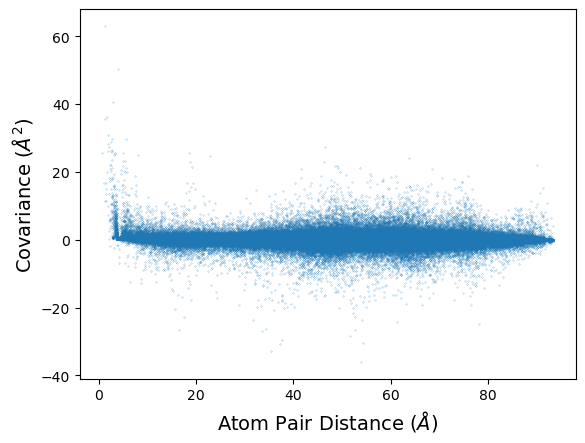

In [29]:
plt.scatter(dist_scatter, covar_scatter, s=0.1, marker=".");
plt.ylabel(r"Covariance ($\AA^2$)", size=14);
plt.xlabel(r"Atom Pair Distance ($\AA$)", size=14);

That looks pretty interesting, but there's a lot going on. What we're really interested in is an overall trend for how atomic covariance depends on distance, on average. To get a better sense of this, we're going to need to create bins for ranges of atom-pair separation distance, and collect all of the atomic covariances in each bin. We'll then compute the average atomic covariance in each bin, as well as the standard error on the mean.

In [30]:
from scipy.stats import sem

In [31]:
def collect_bins(dist, covar, n_bins=50):
    dist_bins = np.linspace(np.min(dist), np.max(dist), num=n_bins)
    bin_indices = np.digitize(dist, dist_bins)
    averages = [np.mean(covar[bin_indices == i]) for i in range(1,n_bins)]
    std_e = [sem(covar[bin_indices == i]) for i in range(1,n_bins)]
    dist_bins = dist_bins - (dist_bins[1]-dist_bins[0])/2
    
    return dist_bins[1:], averages, std_e

This function outputs the distance bin, average atomic covariance, and standard error on the mean to a data file, with each value in a separate column.

In [32]:
def output_data(d, c, s, fn="data.txt"):
    with open(fn, "w") as fo:
        for i in range(len(d)):
            fo.write("{:.5f}, {}, {}\n".format(d[i], c[i], s[i]))

In [33]:
Dist, Cov, Cov_err = collect_bins(dist_scatter, covar_scatter)
output_data(Dist, Cov, Cov_err, "AMBER_full_supercell_covar_vs_dist_FULL_DATA_xf.dat")

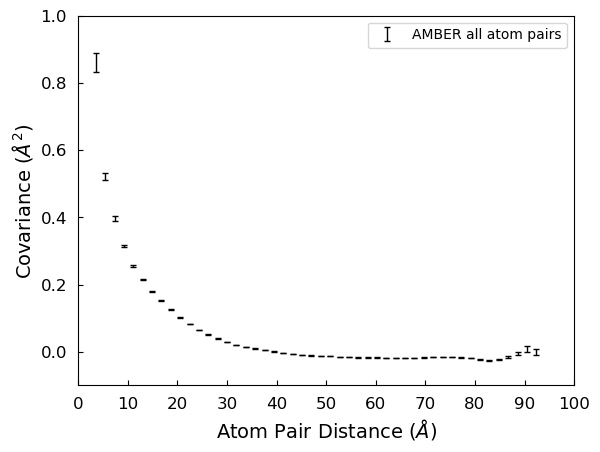

In [34]:
f, ax = plt.subplots()
ax.errorbar(Dist, Cov, yerr=Cov_err, elinewidth=1, capsize=2.5, color="k", linestyle='', label="AMBER all atom pairs")
ax.set_xticks(np.arange(0,110,10))
ax.legend(loc="upper right")
ax.set_ylabel(r"Covariance ($\AA^2$)", size=14)
ax.set_xlabel(r"Atom Pair Distance ($\AA$)", size=14)
ax.tick_params(axis="both", direction="in", labelsize=12, pad=8)
ax.set_ylim([-0.1,1]);
ax.set_xlim([0,100]);

Looks like the relationship is roughly exponential! But we need to check to be sure.

We're going to use `gnuplot`'s `fit` method to compute the parameters for an exponential fit to this data. 

The following writes out a script (`fit.gnu`) that `gnuplot` will run to specify the fit function and the parameters, restrict the fitting to a range of x values, and compute the fit parameters, which are outputted to a `fit.log` file.

In [35]:
with open("fit.gnu", 'w') as g:
    g.write("f(x) = a * exp(-x/g) + b\n")
    g.write("set xrange [5:55.5]\n")
    g.write("fit f(x) \"AMBER_full_supercell_covar_vs_dist_FULL_DATA_xf.dat\" using 1:2:3 via a, g, b\n")

In [36]:
!gnuplot fit.gnu

"fit.gnu" line 3: warning: 
	> Implied independent variable y not found in fit function.
	> Assuming version 4 syntax with zerror in column 3 but no zerror keyword.

iter      chisq       delta/lim  lambda   a             g             b            
   0 9.7248239094e+07   0.00e+00  1.10e+03    1.000000e+00   1.000000e+00   1.000000e+00
   1 1.4761113956e+05  -6.58e+07  1.10e+02    1.000024e+00   1.000152e+00   2.047687e-02
   2 1.3316175292e+05  -1.09e+04  1.10e+01    1.002453e+00   1.015787e+00   8.385406e-03
   3 1.2440382082e+05  -7.04e+03  1.10e+00    1.255163e+00   2.618496e+00   8.375501e-03
   * 1.7571363036e+09   1.00e+05  1.10e+01   -1.986691e+01   2.330565e+01   4.463745e-03
   * 1.2642022096e+05   1.59e+03  1.10e+02    2.566330e-02   9.730779e+00   6.016623e-03
   4 1.1449548191e+05  -8.65e+03  1.10e+01    1.495144e+00   3.094164e+00   8.004156e-03
   * 1.5897849687e+06   9.28e+04  1.10e+02   -1.883127e+00   9.984469e+00   4.230129e-03
   5 9.2107333171e+04  -2.43e+04  1.10

This helper function grabs the fit parameters from the `gnuplot` log file.

In [37]:
def read_parameters(log_file):
    with open(log_file, 'r') as f:
        for line in f.readlines():
            if "a               =" in line:
                a = float(line.split()[2])
            if "g               =" in line:
                g = float(line.split()[2])
            if "b               =" in line:
                b = float(line.split()[2])
    
    print(f"a = {a}")
    print(f"g = {g}")
    print(f"b = {b}")
                
    return a, g, b

Let's see if an exponential fit is any good...

a = 0.787864
g = 11.0136
b = -0.0217781


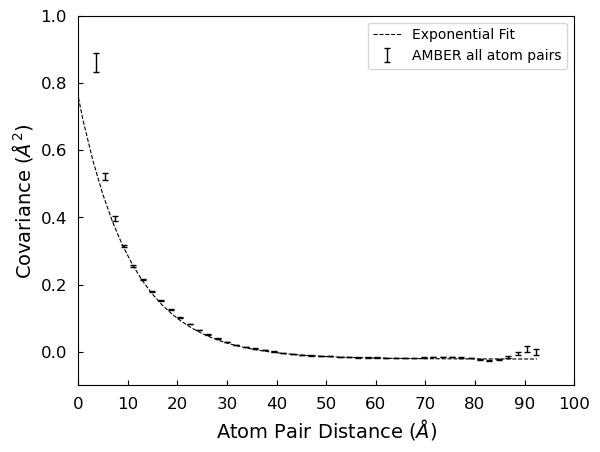

In [38]:
a, g, b = read_parameters("fit.log")

f, ax = plt.subplots()

ax.errorbar(Dist[1:], Cov[1:], yerr=Cov_err[1:], elinewidth=1, capsize=2.5, color="k", linestyle='', label="AMBER all atom pairs")
ax.plot(np.linspace(-5,92.5), a*np.exp(-np.linspace(-5,95)/g)+b, c="k", lw=0.8, ls="--", label="Exponential Fit")
ax.set_xticks(np.arange(0,110,10))
ax.legend(loc="upper right")
ax.set_ylabel(r"Covariance ($\AA^2$)", size=14)
ax.set_xlabel(r"Atom Pair Distance ($\AA$)", size=14)
ax.tick_params(axis="both", direction="in", labelsize=12, pad=8)
ax.set_ylim([-0.1,1]);
ax.set_xlim([0,100]);

Looks pretty good to me!

### Selecting atom-pairs within the protein

What we just plotted was the relationship between atomic covariance and distance for _all atom pairs_ across the whole supercell. In our paper, we show that this relationship also holds for all atom pairs _across_ proteins.

Now we want to see if the same relationship holds for atom pairs _within_ proteins.

In the supercell simulation, each protein is 149 residues long, but the x-ray structural model for the system only contains residues 5-140 because the N- and C-termini are flexible, and were unresolved in by the crystallography. 

We're going to use the X-ray structure to produce a rigid-body motions model for the protein shortly, so to make sure that our predictions from the model can be adequately compared with this model, we're going to compute relationship between atomic covariance and atom-pair separation distance for only the atom-pairs 5-140 of each protein. 

This means selecting the indices associated with residues 5-140 for each 149x149 matrix along the diagonals. Below is the code to select for only those elements, and bin them as before.

In [39]:
# The code block below will issue a RuntimeWarning, this code block suppresses this warning, as it is expected
import warnings
warnings.filterwarnings('ignore')

In [40]:
dist_within = []
covar_within = []
for i in range(32):
    dist_within.append(  dist[i*149+5:i*149+140, i*149+5:i*149+140])
    covar_within.append(covar[i*149+5:i*149+140, i*149+5:i*149+140])

dist_within_scatter = np.array(dist_within).flatten()
covar_within_scatter = np.array(covar_within).flatten()

DistW, CovW, CovW_err = collect_bins(dist_within_scatter, covar_within_scatter);

In [41]:
warnings.filterwarnings('default')

Bins at low separation distance: 0.43 A and 1.29 A


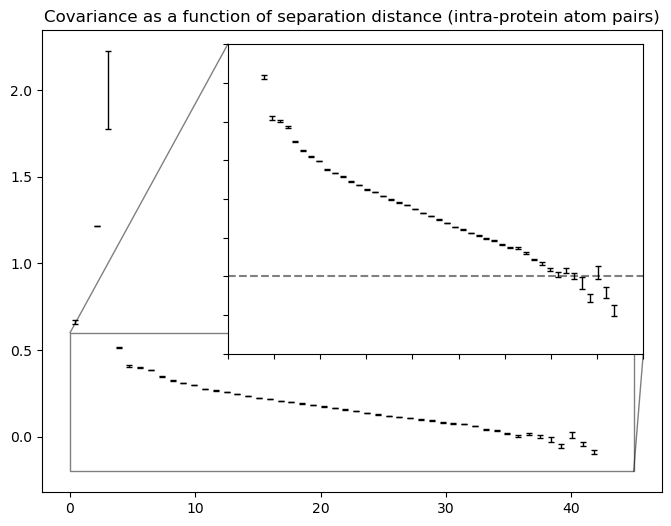

In [42]:
f, ax = plt.subplots(figsize=(8,6))
ax.errorbar(DistW, CovW, yerr=CovW_err,elinewidth=1, capsize=2.5, color="k", linestyle='', label="AMBER all atom pairs")
ax.set_title("Covariance as a function of separation distance (intra-protein atom pairs)")

## INSET ###
axins = ax.inset_axes([0.3, 0.3, 0.67, 0.67])
axins.axhline(0, lw=1.5, ls="--", c="Gray")
axins.errorbar(DistW, CovW, CovW_err, elinewidth=1, capsize=2.5, color="k", linestyle='', label="AMBER all atom pairs");
## sub region of the original image
x1, x2, y1, y2 = 0, 45, -0.2, 0.6
axins.set_xlim(x1, x2);
axins.set_ylim(y1, y2);
axins.set_xticklabels([]);
axins.set_yticklabels([]);
############

ax.indicate_inset_zoom(axins, edgecolor="black");

print("Bins at low separation distance: {:.2f} A and {:.2f} A".format(DistW[0], DistW[1]))

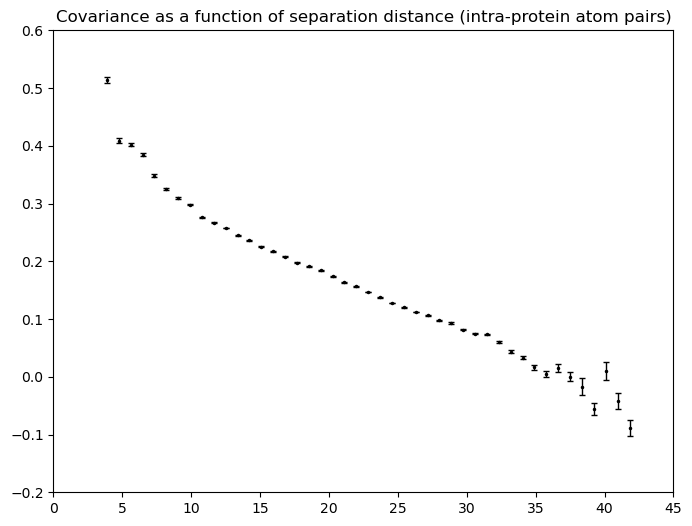

In [43]:
f, ax = plt.subplots(figsize=(8,6))
ax.errorbar(DistW, CovW, yerr=CovW_err, elinewidth=1, capsize=2.5, color="k", marker=".", markersize=3, linestyle='', label="AMBER all atom pairs")
ax.set_xlim([0,45])
ax.set_ylim([-0.2, 0.6])
ax.set_title("Covariance as a function of separation distance (intra-protein atom pairs)");

Huh, that doesn't look very exponential. Almost looks linear. In the lecture notes from this talk at the Erice International School of Crystallography, an argument is laid out for why this kind of roughly-linear relationship might be indicative of Rigid-body-motions-like dynamics.

To test to what degree this relationship between atom-pair separation distance and atomic covariance is explained by a rigid body motions model, we'll take the x-ray structure (again, missing residues 1-5 and 141-149) and compute the relationship between atom-pair separation distance and atomic covariance for pure rigid body motions with a particular amount of rotation and translation (specified by a standard deviation in the sampling of euler angles, and a standard deviation of in the sampling of translations along each axis). This is done using the `RigidBodyMotions.py` method in this directory. The `Model` class does all this work for us, and outputs the distance and covariance information on the same scale as the covariance data from the simulation.

In [44]:
warnings.filterwarnings('ignore')

(-0.2, 0.6)

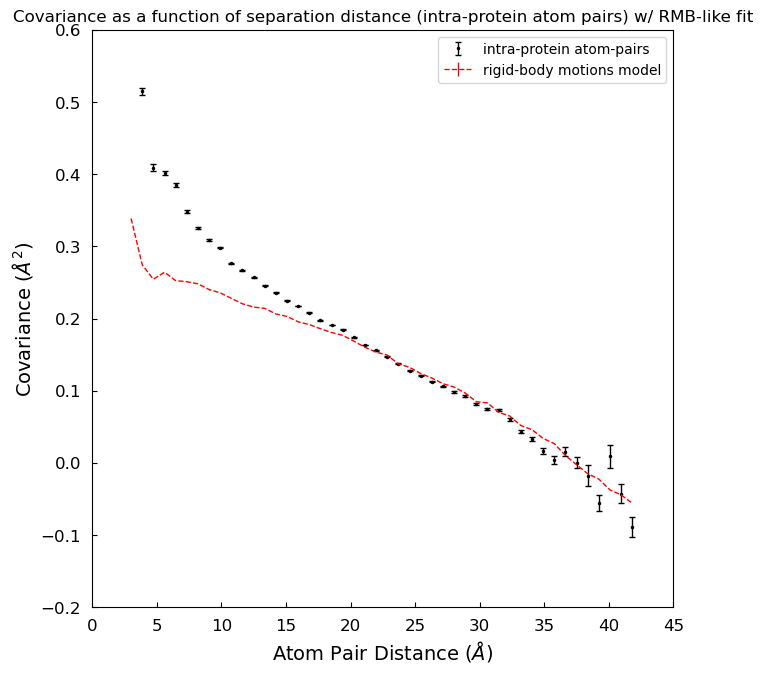

In [45]:
import sys
sys.path.append('./code/')
from RigidBodyMotions import *
DistRBM, CovarRBM, semRBM = Model(dist=DistW, ROT_STD=0.95, TRANS_STD=0.024, N_FRAMES=20000).run()
f, ax = plt.subplots(figsize=(7.5,7.5))
ax.errorbar(DistW, CovW, yerr=CovW_err, elinewidth=1, capsize=2.5, color="k", marker=".", markersize=3, linestyle='', label="intra-protein atom-pairs")
ax.set_title("Covariance as a function of separation distance (intra-protein atom pairs) w/ RMB-like fit")
ax.errorbar(DistRBM, 100*CovarRBM, yerr=semRBM, color="r", lw=1, ls="--", label="rigid-body motions model")
ax.legend(loc="upper right");
ax.set_ylabel(r"Covariance ($\AA^2$)", size=14)
ax.set_xlabel(r"Atom Pair Distance ($\AA$)", size=14)
ax.tick_params(axis="both", direction="in", labelsize=12, pad=8)
ax.set_xlim([0,45])
ax.set_ylim([-0.2, 0.6])

In [46]:
warnings.filterwarnings('default')

Hmmm... it looks like the rigid-body motions model explains a lot of the covariance beyond about 20 angstroms, but what about the covariance from 0-20 angstroms?

Let's look at the residual between the two:

(-0.1, 0.3)

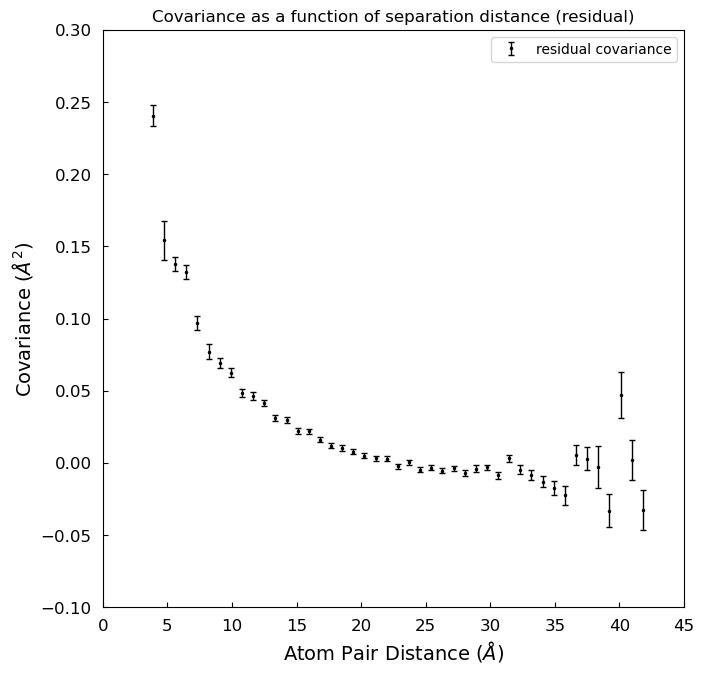

In [47]:
residual = CovW - 100*CovarRBM
residual_err = np.sqrt(np.add(np.power(CovW_err, 2), np.power(100*semRBM, 2)))
f, ax = plt.subplots(figsize=(7.5,7.5))
ax.errorbar(DistW, residual, yerr=residual_err, elinewidth=1, capsize=2.5, color="k", marker=".", markersize=3, linestyle='', label="residual covariance")
ax.set_title("Covariance as a function of separation distance (residual)")
ax.legend(loc="upper right");
ax.set_ylabel(r"Covariance ($\AA^2$)", size=14)
ax.set_xlabel(r"Atom Pair Distance ($\AA$)", size=14)
ax.tick_params(axis="both", direction="in", labelsize=12, pad=8)
ax.set_xlim([0,45])
ax.set_ylim([-0.1, 0.3])

That looks pretty exponential, just like before!

Let's output the data again, and fit to an exponential:

In [48]:
output_data(DistW, residual, residual_err, "residual_covar_vs_dist.dat")

In [49]:
with open("fit_residual.gnu", 'w') as g:
    g.write("f(x) = a * exp(-x/g) + b\n")
    g.write("fit f(x) \"residual_covar_vs_dist.dat\" using 1:2:3 via a, g, b\n")

In [50]:
!gnuplot fit_residual.gnu

"fit_residual.gnu" line 2: warning: 
	> Implied independent variable y not found in fit function.
	> Assuming version 4 syntax with zerror in column 3 but no zerror keyword.

iter      chisq       delta/lim  lambda   a             g             b            
   0 7.2110510831e+06   0.00e+00  2.34e+02    1.000000e+00   1.000000e+00   1.000000e+00
   1 5.3092953439e+03  -1.36e+08  2.34e+01    1.002063e+00   1.009274e+00   1.895963e-02
   2 3.2351125030e+03  -6.41e+04  2.34e+00    1.168868e+00   1.774310e+00   1.129939e-02
   * 2.5703669554e+05   9.87e+04  2.34e+01   -2.608790e+00   4.940405e+00   5.654522e-03
   3 1.4076862026e+03  -1.30e+05  2.34e+00    1.327440e+00   2.486206e+00   8.238048e-03
   * 1.8382877393e+04   9.23e+04  2.34e+01   -4.755574e-01   4.182658e+00   1.383553e-03
   4 9.9946005213e+02  -4.08e+04  2.34e+00    1.065003e+00   2.883145e+00   4.777804e-03
   * 6.7168267359e+03   8.51e+04  2.34e+01   -1.890832e-02   4.461603e+00  -5.388640e-04
   5 7.0640977953e+02  -4.15e

a = 0.416831
g = 5.63922
b = -0.00705936


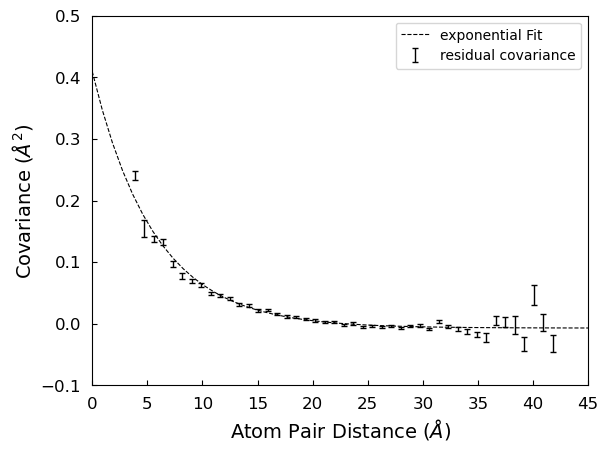

In [51]:
a, g, b = read_parameters("fit.log")

f, ax = plt.subplots()

ax.errorbar(DistW, residual, yerr=residual_err, elinewidth=1, capsize=2.5, color="k", linestyle='', label="residual covariance")
ax.plot(np.linspace(0, 45.0), a*np.exp(-np.linspace(0, 45.0)/g)+b, c="k", lw=0.8, ls="--", label="exponential Fit")
ax.legend(loc="upper right")
ax.set_ylabel(r"Covariance ($\AA^2$)", size=14)
ax.set_xlabel(r"Atom Pair Distance ($\AA$)", size=14)
ax.tick_params(axis="both", direction="in", labelsize=12, pad=8)
ax.set_ylim([-0.1,0.5]);
ax.set_xlim([0,45]);

So, it looks like the relationship between atom pair separation distance and atomic covariance is well explained by a combination of rigid-body and liquid like motions!

For more on this, see our paper in [Structural Dynamics](https://aca.scitation.org/doi/10.1063/1.5132692).